<a href="https://colab.research.google.com/github/kangmg/image2music/blob/main/backend/data/get_music_data_and_mel_spec_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Mel spectrogram 얻기**

LastFM을 이용하여 수집한 meta data(youtube url을 포함)로부터 유튜브 음원을 추출하고 이를 mel spectrogram으로 변환 후 저장하는 노트북

`프로젝트 기간이 종료된 후 작동하지 않을 수 있음`

1. 코드를 실행시키면, mel_array.zip 형태로 전체 mel spectrogram이 압축 저장되고, 각 mel spectrogram은 *.npy 형태의 넘파이 바이너리 파일로 저장됨

2. 파일을 로드하고 싶으면 다음 코드로 plot 가능함

```python
import numpy as np
import matplotlib.pyplot as plt

data_path = 'path/to/mel_spectrogram/data'
np_array = np.load(data_path)
plt.imshow(np_array, aspect='auto' , cmap="afmhot")
```


In [1]:
#@title 데이터 및 패키지 다운로드
#@markdown meta data와 음성 데이터를 다루기 위한 패키지를 다운로드 합니다.

# meta data download
!git clone -q https://github.com/kangmg/image2music
!mkdir metadata
!mv ./image2music/backend/data/clusters_meta/* ./metadata
!rm -r ./image2music

# package downlaod
!pip install -q pytube
!pip install -q ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 779.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [39]:
#@title setting

from pytube import YouTube
import time
import os
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.io import wavfile
from IPython.display import clear_output
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_audio
from scipy.io.wavfile import write
import glob
import shutil
import matplotlib.pyplot as plt
import subprocess

def convertor(path, id, sampling_rate=22050):
    '''
    mp4 -> wav (first 30 seconds)
    Ensure the audio has a consistent length of sampling_rate * 30 samples.
    sampling_rate: sampling rate for the output audio file (default is 22050 Hz)
    '''
    input_path = os.path.join(path, f"{id}.mp4")
    output_wav_path = os.path.join(path, f"{id}.wav")
    temp_output_path = os.path.join(path, f"{id}_temp.wav")
    # Extract audio from the video using ffmpeg directly
    ffmpeg_extract_audio(input_path, temp_output_path, fps=sampling_rate, )
    time.sleep(0.1)
    # Load the audio data from the temporary file
    sr, audio_array = wavfile.read(temp_output_path)
    # Ensure the audio has a consistent length of sampling_rate * 30 samples
    target_length = int(sampling_rate * 30)
    # Flatten to mono if stereo
    if audio_array.ndim > 1:
        audio_array = audio_array.mean(axis=1)
    # ensure 30 sec
    audio_array = audio_array[:target_length]
    # Save the adjusted audio data to the output path
    write(output_wav_path, sampling_rate, audio_array)

    # Remove the temporary and original MP4 files
    os.remove(temp_output_path)
    os.remove(input_path)


def downUrl(url:str,download_path="/content/audio/", sr=22050)->None:
  '''
  url에 해당하는 유튜브 영상을 오디오 형식으로 저장
  '''
  yt = YouTube(url)
  yt_id = yt.video_id
  audio = yt.streams.filter(only_audio=True, audio_codec="mp4a.40.5" if True else "mp4a.40.2")[0] # 변경 필요
  name = yt_id + ".mp4"
  try:
    audio.download(output_path=download_path, filename=name)
    time.sleep(0.2)
    convertor(download_path, yt_id,  sampling_rate=sr)
  except Exception as E:
    print("[Warning] ",audio.video_id, " : 영상 다운 실패")

def normalize(spec):
    '''
    normalize mel spectrogram array
    '''
    eps=1e-6

    # Z-score normalization
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()

    # Min-max scaling
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)

    return spec_scaled


def save_mel_spectrogram(wav_file, save_path):
    '''
    Generate and save Mel spectrogram as a NumPy array.

    Parameters:
    wav_file (str): Path to the input WAV file.
    save_path (str): Path to save the Mel spectrogram array.
    '''
    y, sr = librosa.load(wav_file)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_dB = normalize(S_dB)
    np.save(save_path, S_dB)


def process_wav_files(input_dir, output_dir="auto"):
  '''
  input_dir에 존재한 *.wav 파일을 output_dir에
  mel spectrogram array를 *.npy로 저장
  '''
  if output_dir == "auto":
    output_dir = input_dir + "_mel"
    os.mkdir(output_dir)
  else:
    if not os.path.isdir(output_dir):
      os.mkdir(output_dir)


  files = os.listdir(input_dir)
  for file in tqdm(files):
    if file.endswith('.wav'):
      wav_file = os.path.join(input_dir, file)
      save_mel_spectrogram(wav_file, os.path.join(output_dir, file.replace('.wav', '.npy')))

def compress2targz(folder_path, output_filename='auto'):
    """
    압축하고자 하는 폴더를 tar.gz 형식으로 압축하는 함수
    """
    if output_filename == 'auto':
        output_filename = f"{folder_path}.tar.gz"
    try:
        subprocess.run(['tar', '-czvf', output_filename, folder_path], check=True)
        print(f"Successfully compressed! :  {output_filename}")
    except subprocess.CalledProcessError as e:
        print(f"Fail to compress")


if not os.path.isdir('./mel_spectrogram'):
  os.mkdir('./mel_spectrogram')

# 다운로드 실패 url 리스트
failed_url = list()

```
각 셀마다 20~50 분정도의 run time이 걸림

전체 약 35 m * 9 = 315 m ( ~ 6 h )
```

In [22]:
#@title cluster A

# set mood cluster
cluster = "A_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r A_cluster.zip mel_spectrogram/A_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of A_cluster ]
Number of mel spectrogram : 230


In [24]:
#@title cluster B

# set mood cluster
cluster = "B_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r B_cluster.zip mel_spectrogram/B_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of B_cluster ]
Number of mel spectrogram : 449


In [25]:
#@title cluster C

# set mood cluster
cluster = "C_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r C_cluster.zip mel_spectrogram/C_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of C_cluster ]
Number of mel spectrogram : 255


In [26]:
#@title cluster D

# set mood cluster
cluster = "D_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r D_cluster.zip mel_spectrogram/D_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of D_cluster ]
Number of mel spectrogram : 480


In [27]:
#@title cluster E

# set mood cluster
cluster = "E_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r E_cluster.zip mel_spectrogram/E_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of E_cluster ]
Number of mel spectrogram : 451


In [28]:
#@title cluster F

# set mood cluster
cluster = "F_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r F_cluster.zip mel_spectrogram/F_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of F_cluster ]
Number of mel spectrogram : 466


In [29]:
#@title cluster G

# set mood cluster
cluster = "G_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r G_cluster.zip mel_spectrogram/G_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of G_cluster ]
Number of mel spectrogram : 279


In [30]:
#@title cluster H

# set mood cluster
cluster = "H_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r H_cluster.zip mel_spectrogram/H_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of H_cluster ]
Number of mel spectrogram : 390


In [31]:
#@title cluster I

# set mood cluster
cluster = "I_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r I_cluster.zip mel_spectrogram/I_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of I_cluster ]
Number of mel spectrogram : 172


In [32]:
#@title cluster J

# set mood cluster
cluster = "J_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r J_cluster.zip mel_spectrogram/J_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of J_cluster ]
Number of mel spectrogram : 401


In [33]:
#@title cluster K

# set mood cluster
cluster = "K_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r K_cluster.zip mel_spectrogram/K_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of K_cluster ]
Number of mel spectrogram : 465


In [34]:
#@title cluster L

# set mood cluster
cluster = "L_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r L_cluster.zip mel_spectrogram/L_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of L_cluster ]
Number of mel spectrogram : 399


In [35]:
#@title cluster M

# set mood cluster
cluster = "M_cluster"

file_list = glob.glob(f"./metadata/{cluster}/*.csv")
mood_list = list(os.path.basename(path).split(".")[0] for path in file_list)

# file download
for mood, file in zip(mood_list, file_list):
  tmp_df = pd.read_csv(f'{file}')
  os.mkdir(mood)
  print(f"- {mood} Progress")
  for yt_url in tqdm(tmp_df['youtube_url']):
    try:
      downUrl(url=yt_url, download_path=mood)
    except Exception as E:
      print(f"{E}\n")
      print("[Warning] Fail to download : ",yt_url)
      failed_url.append(yt_url)
  clear_output()

!echo "Download Done!"

#get mel spectrogram
for mood in mood_list:
  process_wav_files(f"./{mood}", f"./mel_spectrogram/{cluster}")
  clear_output()

# 파일 압축
!zip -r M_cluster.zip mel_spectrogram/M_cluster
clear_output()

total_num = len(glob.glob(f'./mel_spectrogram/{cluster}/*.npy'))
print(f'[ Num of {cluster} ]')
print(f"Number of mel spectrogram : {total_num}")

[ Num of M_cluster ]
Number of mel spectrogram : 326


In [40]:
#@title 음원 파일 압축

# wav가 담긴 폴더 리스트
all_mood_list = list(os.path.basename(path).split(".")[0] for path in glob.glob("./metadata/*_cluster/*.csv"))

# wav_data 폴더 생성
if os.path.isdir("wav_data"):
  os.mkdir("wav_dir")

# 폴더 이동
for wav_dir in all_mood_list:
  shutil.move(wav_dir, "wav_data" )

# 압축
compress2targz("wav_data")

clear_output()

!echo "wav_data compression Done!"

wav_data compression Done!


In [46]:
#@title 전체 파일 압축
total_files = glob.glob('./mel_spectrogram/*_cluster/*.npy')

# 압축
!tar -czvf mel_spectrogram.tar.gz mel_spectrogram

clear_output()
!echo "Compression Done!"

!echo 전체 파일 수 : {len(total_files)}

Compression Done!
전체 파일 수 : 4763


> *mel spectrogram 예시 출력*

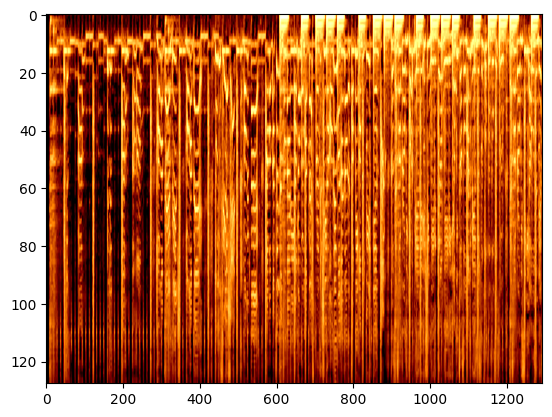

In [52]:
plt.imshow(np.load('/content/mel_spectrogram/B_cluster/4r9TbKLCus0.npy'),aspect='auto' , cmap="afmhot")

> mel spectrogram 다운로드 방법

```python
# mel spectrogram 파일 다운로드
!wget 'https://drive.usercontent.google.com/download?id=1-JMMBNkmV72ss_NYdAl3q9hhsIrmNojk&export=download&authuser=1&confirm=t' -O ./mel_spectrogram.tar.gz

# 압축 해제 코드
!tar -xzvf mel_spectrogram.tar.gz -C ./mel_spectrogram
```

In [ ]:
#@title `mel spectrogram` 다운로드 실행코드

# mel spectrogram 파일 다운로드
!wget 'https://drive.usercontent.google.com/download?id=1-JMMBNkmV72ss_NYdAl3q9hhsIrmNojk&export=download&authuser=1&confirm=t' -O ./mel_spectrogram.tar.gz

# 압축 해제 코드
!tar -xzvf mel_spectrogram.tar.gz -C ./mel_spectrogram

> wav 파일 다운로드

```python
# ( 최대 ) 30s 짜리 wav 파일 다운로드 / 4763 개 데이터  
# ( NOTE ) 유튜브 음원이 예를 들어 14초일 수도 있어서 최대 30초 음원임
!wget 'https://drive.usercontent.google.com/download?id=1-TFbEFKa1UzT8I9_yoHMkfb0YhSqnr02&export=download&authuser=1&confirm=t' -O ./music_wav.tar.gz

# 파일 압축 해제
!tar -xzvf music_wav.tar.gz -C ./wav_data

# 압축 실수로 경로 재변경
!mkdir ./wav_data/Relaxing
!mv ./wav_data/*.wav ./wav_data/Relaxing
```

In [ ]:
#@title `wav data` 실행 코드

# ( 최대 ) 30s 짜리 wav 파일 다운로드 / 4763 개 데이터
# ( NOTE ) 유튜브 음원이 예를 들어 14초일 수도 있어서 최대 30초 음원임
!wget 'https://drive.usercontent.google.com/download?id=1-TFbEFKa1UzT8I9_yoHMkfb0YhSqnr02&export=download&authuser=1&confirm=t' -O ./music_wav.tar.gz

# 파일 압축 해제
!tar -xzvf music_wav.tar.gz -C ./wav_data

# 압축 실수로 경로 재변경
!mkdir ./wav_data/Relaxing
!mv ./wav_data/*.wav ./wav_data/Relaxing